# Exploring Wage Theft by MSA by NAICS3

In the preceding part of this exercise, we managed to clean and combine the WHD wage theft data with the Census Bureau's employment workforce data by MSA, albeit for California only. Let's now look at this dataset and see what we can infer from it.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbrn
from sklearn.cluster import k_means
from sklearn.preprocessing import scale
import numpy as np
import scipy.cluster.vq as scp_vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load the prepared dataset
dat = pd.read_csv('./../data/california_violtns_MSA_NAICS3.csv')

In [222]:
#let's remind ourselves of how this data looks
pd.set_option('max_columns',50)
dat.sample(3)

,MSA,MSADSCR,NAICS3,NAICS3Desc,MinWage_ATPAmt,BMW_Cases,cmp_assd_cnt,ESTB,MinWage_Cases,case_violtn_cnt,is_violator,ee_atp_cnt,All_ATPAmt,ChildLabor_EmpAff,ee_violtd_cnt,PAYR_N,MinWage_EmpAff,BMW_ATPAmt,BMW_EmpAff,EMPL_N,Other_ATPAmt,Other_Cases,Other_EmpAff,ChildLabor_ATPAmt,ChildLabor_Cases,All_AtpAmt,num_investigations,km_cluster,MW_Vltn_Svrty,BMW_Vltn_Svrty,CL_Vltn_Svrty,OTHER_Vltn_Svrty,OVERALL_Vltn_Svrty
503,41740.0,"San Diego-Carlsbad, CA Metro Area",517,Telecommunications,576903.99,0,0.0,399.0,3359,3359,3,3359,1729330.83,0,3359,929466.0,3359,0.0,0,11470.0,1152426.84,0,0,0.0,0,1729330.83,5,1,168946.861588,0.0,0.0,0.000000,506436.116650
542,41860.0,"San Francisco-Oakland-Hayward, CA Metro Area",326,Plastics and Rubber Products Manufacturing,17400.00,0,0.0,108.0,9,9,1,8,26100.00,0,8,133769.0,8,0.0,0,2678.0,8700.00,0,0,0.0,0,26100.00,2,0,51.979089,0.0,0.0,0.000000,77.968633
833,46700.0,"Vallejo-Fairfield, CA Metro Area",721,Accommodation,25519.66,0,0.0,58.0,75,75,6,71,61558.98,0,73,13928.0,71,0.0,0,770.0,36039.32,0,2,0.0,0,61558.98,8,0,2353.111506,0.0,0.0,93.608623,5836.111091


## Feature Engineering  

While we can look at things like the total Minimum Wage violations by MSA or by Industry, it might not be a true reflection of the real world as the D.O.L. is only able to investigate industries and areas based on *anecdotal evidence*. The data we see therefore, suffer from observation bias - we see more data around certain industries because those are investigated more, but this doesn't necessarily entail that the other industries are exemplars of good conduct. Going by the articles linked to in the intro to the accompanying blog, a majority of exploited workers would rather not report violations for fear of repurcussions.  

So let's look at a few relationships and see how we can engineer some features with respect to something like *investigative payoff*. Ideally, industries and MSAs with violations that are considered to be *severe* deserve to be looked into more than the others. What we need, then, is a measure of **Severity** given the data at hand.  

Let's think of *severe* violators, for an industry group, in a Metropolitan Statistical Area as those industries that owe a high amount of backwages to a larger chunk of the total workforce. The local DOL WHD is concerned with these sorts of violations because it is likely that these affect larger numbers of at-risk populations:  

$ViolationSeverity = BackwagesOwed * ProportionWorkforceAffected$ 

In [156]:
#min. wage
dat['MW_Vltn_Svrty'] = dat['MinWage_ATPAmt'] * dat['MinWage_EmpAff']/dat['EMPL_N']
#below min. wage
dat['BMW_Vltn_Svrty'] = dat['BMW_ATPAmt'] * dat['BMW_EmpAff']/dat['EMPL_N']
#child labor
dat['CL_Vltn_Svrty'] = dat['ChildLabor_ATPAmt'] * dat['ChildLabor_EmpAff']/dat['EMPL_N']
#other
dat['OTHER_Vltn_Svrty'] = dat['Other_ATPAmt'] * dat['Other_EmpAff']/dat['EMPL_N']
#Overall
dat['OVERALL_Vltn_Svrty'] = dat['All_ATPAmt'] * dat['ee_violtd_cnt']/dat['EMPL_N']

Now, let's look at this measure of *severity* for each type of violation by industry groups across California. 

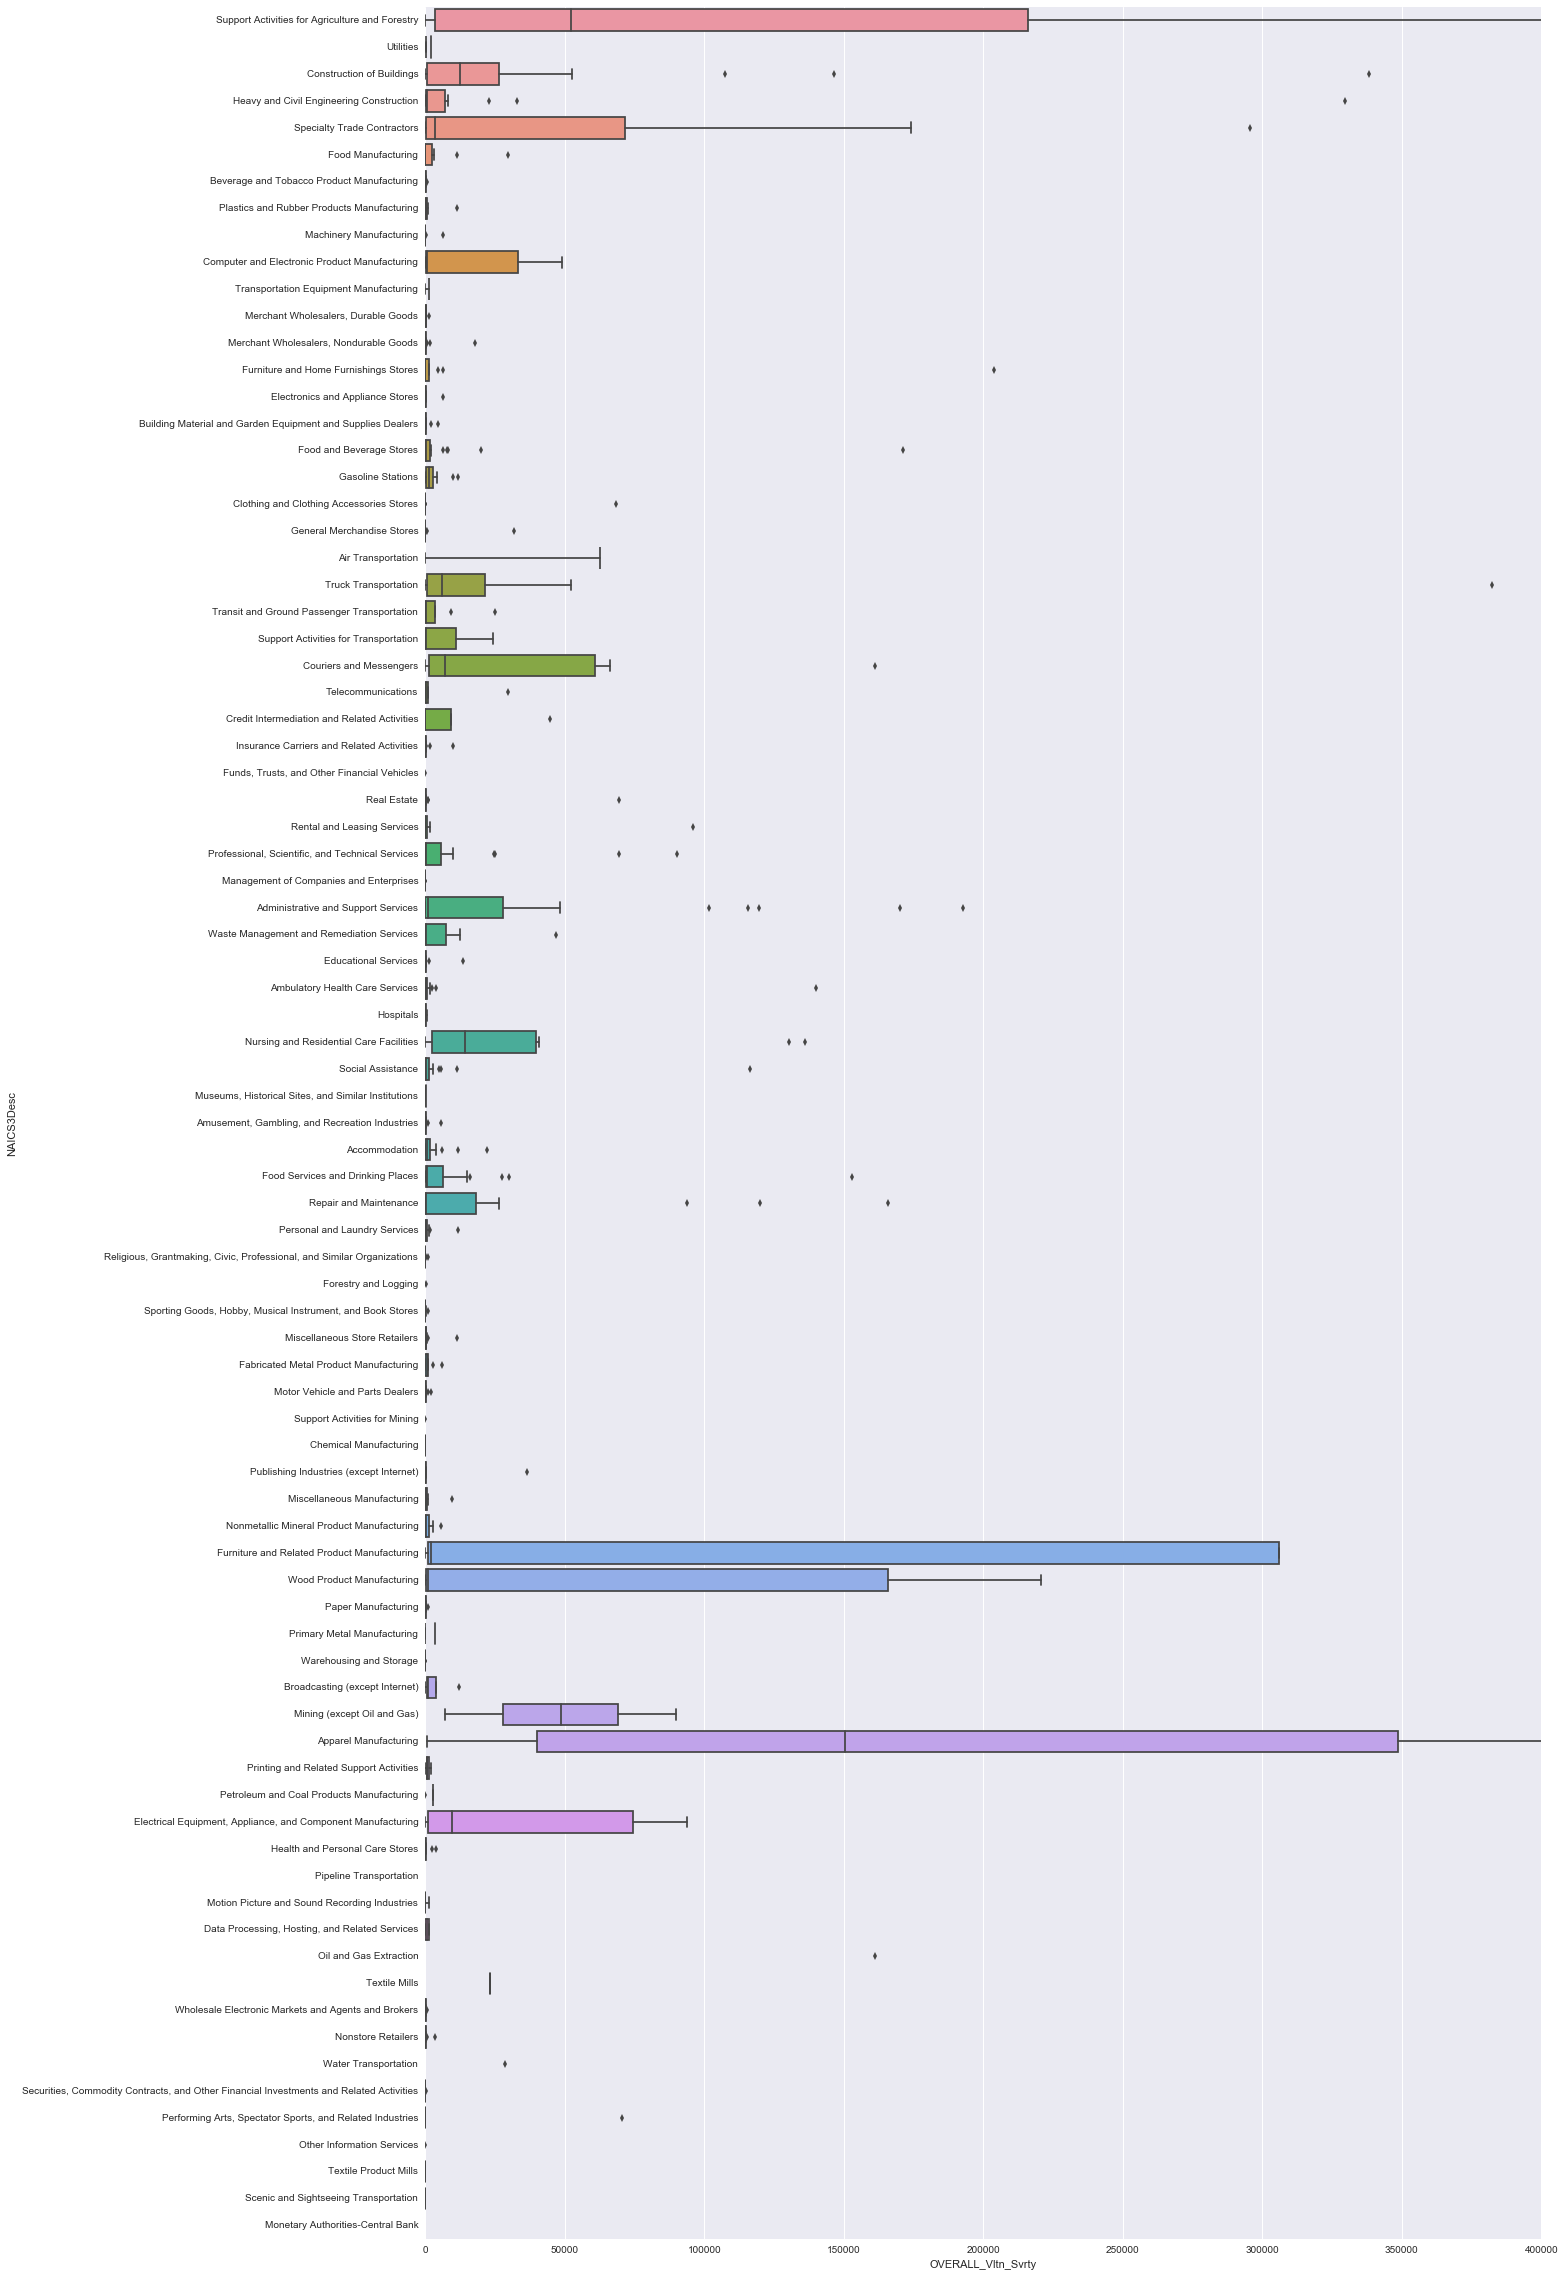

In [224]:
f, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(20,40))
g1 = sbrn.boxplot(data = dat, y='NAICS3Desc', x='OVERALL_Vltn_Svrty',ax=ax1)
g1.set_xlim(0,400000);

Amongst the data we've managed to preserve, we see that *Apparel Manufacturing*, *Furniture and Related Product Manufacturing*, *Wood Product Manufacturing*, *Support Activities for Agriculture and Forestry* have severe variations in *Overall* violation scores. Are these investigated proportionate to the violations? Let's find out by building a Tableau dashboard of charts so we don't have to go through a ton of matplotlib code. We'll save the file as a CSV so we can pick it up in Tableau Public.

In [220]:
dat.to_csv('./../data/california_violtns_MSA_NAICS3.csv')

---

---

# Archive (not used)
Tried k-means clustering but it didn't reveal any clear clusters other than what's already obvious in a scatter plot.

In [7]:
#get only numeric columns:
num_df = dat.iloc[:,4:]

In [64]:
K = range(1, 15) # of clusters to look for

In [65]:
num_df_norm=scp_vq.whiten(num_df)

In [66]:
KM = [scp_vq.kmeans(num_df_norm, k) for k in K]

In [67]:
centroids = [cent for (cent,var) in KM]

In [71]:
D_k=[cdist(num_df_norm, cent, 'euclidean') for cent in centroids]

In [72]:
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/num_df_norm.shape[0] for d in dist]

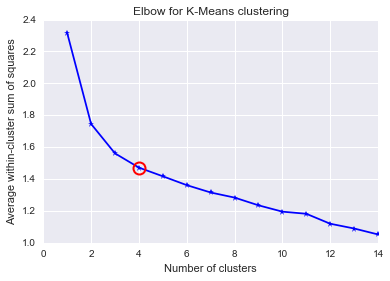

In [74]:
kIdx = 3
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [96]:
from sklearn.cluster import KMeans
km = KMeans(3, init='k-means++', n_init=50, max_iter=5000) # initialize
km.fit(num_df_norm)
c = km.predict(num_df_norm) # classify into three clusters

In [97]:
dat['km_cluster'] = c

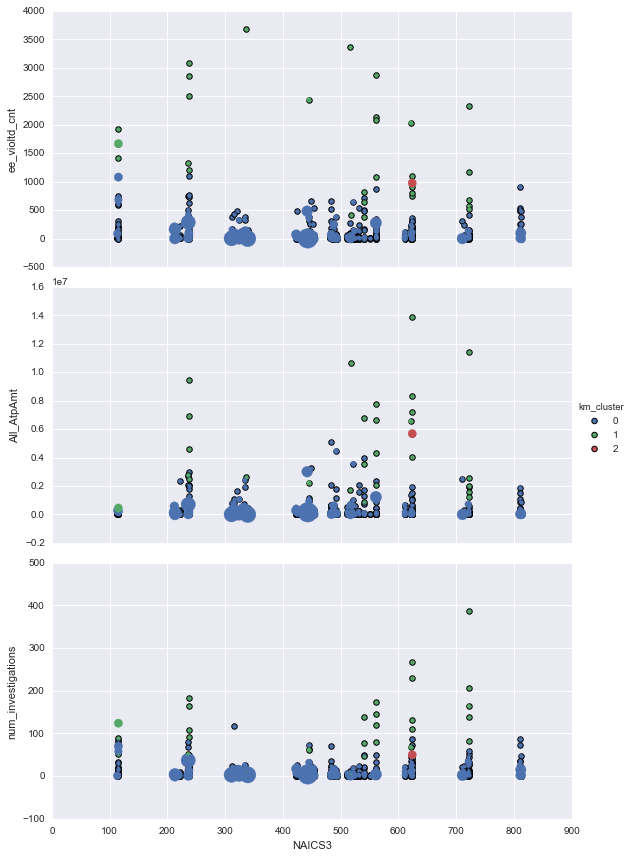

In [127]:
# g=sbrn.pairplot(dat, 
#               hue='km_cluster', 
#               hue_order=None, 
#               palette=None, 
#               vars=None, 
#               x_vars='NAICS3', 
#               y_vars=['ee_violtd_cnt', 'All_AtpAmt','num_investigations'],
#               #kind='scatter', 
#               #diag_kind='hist', 
#               markers='o', 
#               size=4, 
#               aspect=2, 
#               dropna=False, 
#               plot_kws=dict(s=30, edgecolor="black", linewidth=1), 
#               diag_kws=None, 
#               grid_kws=None)

# g.map(plt.scatter, s=dat.num_investigations)

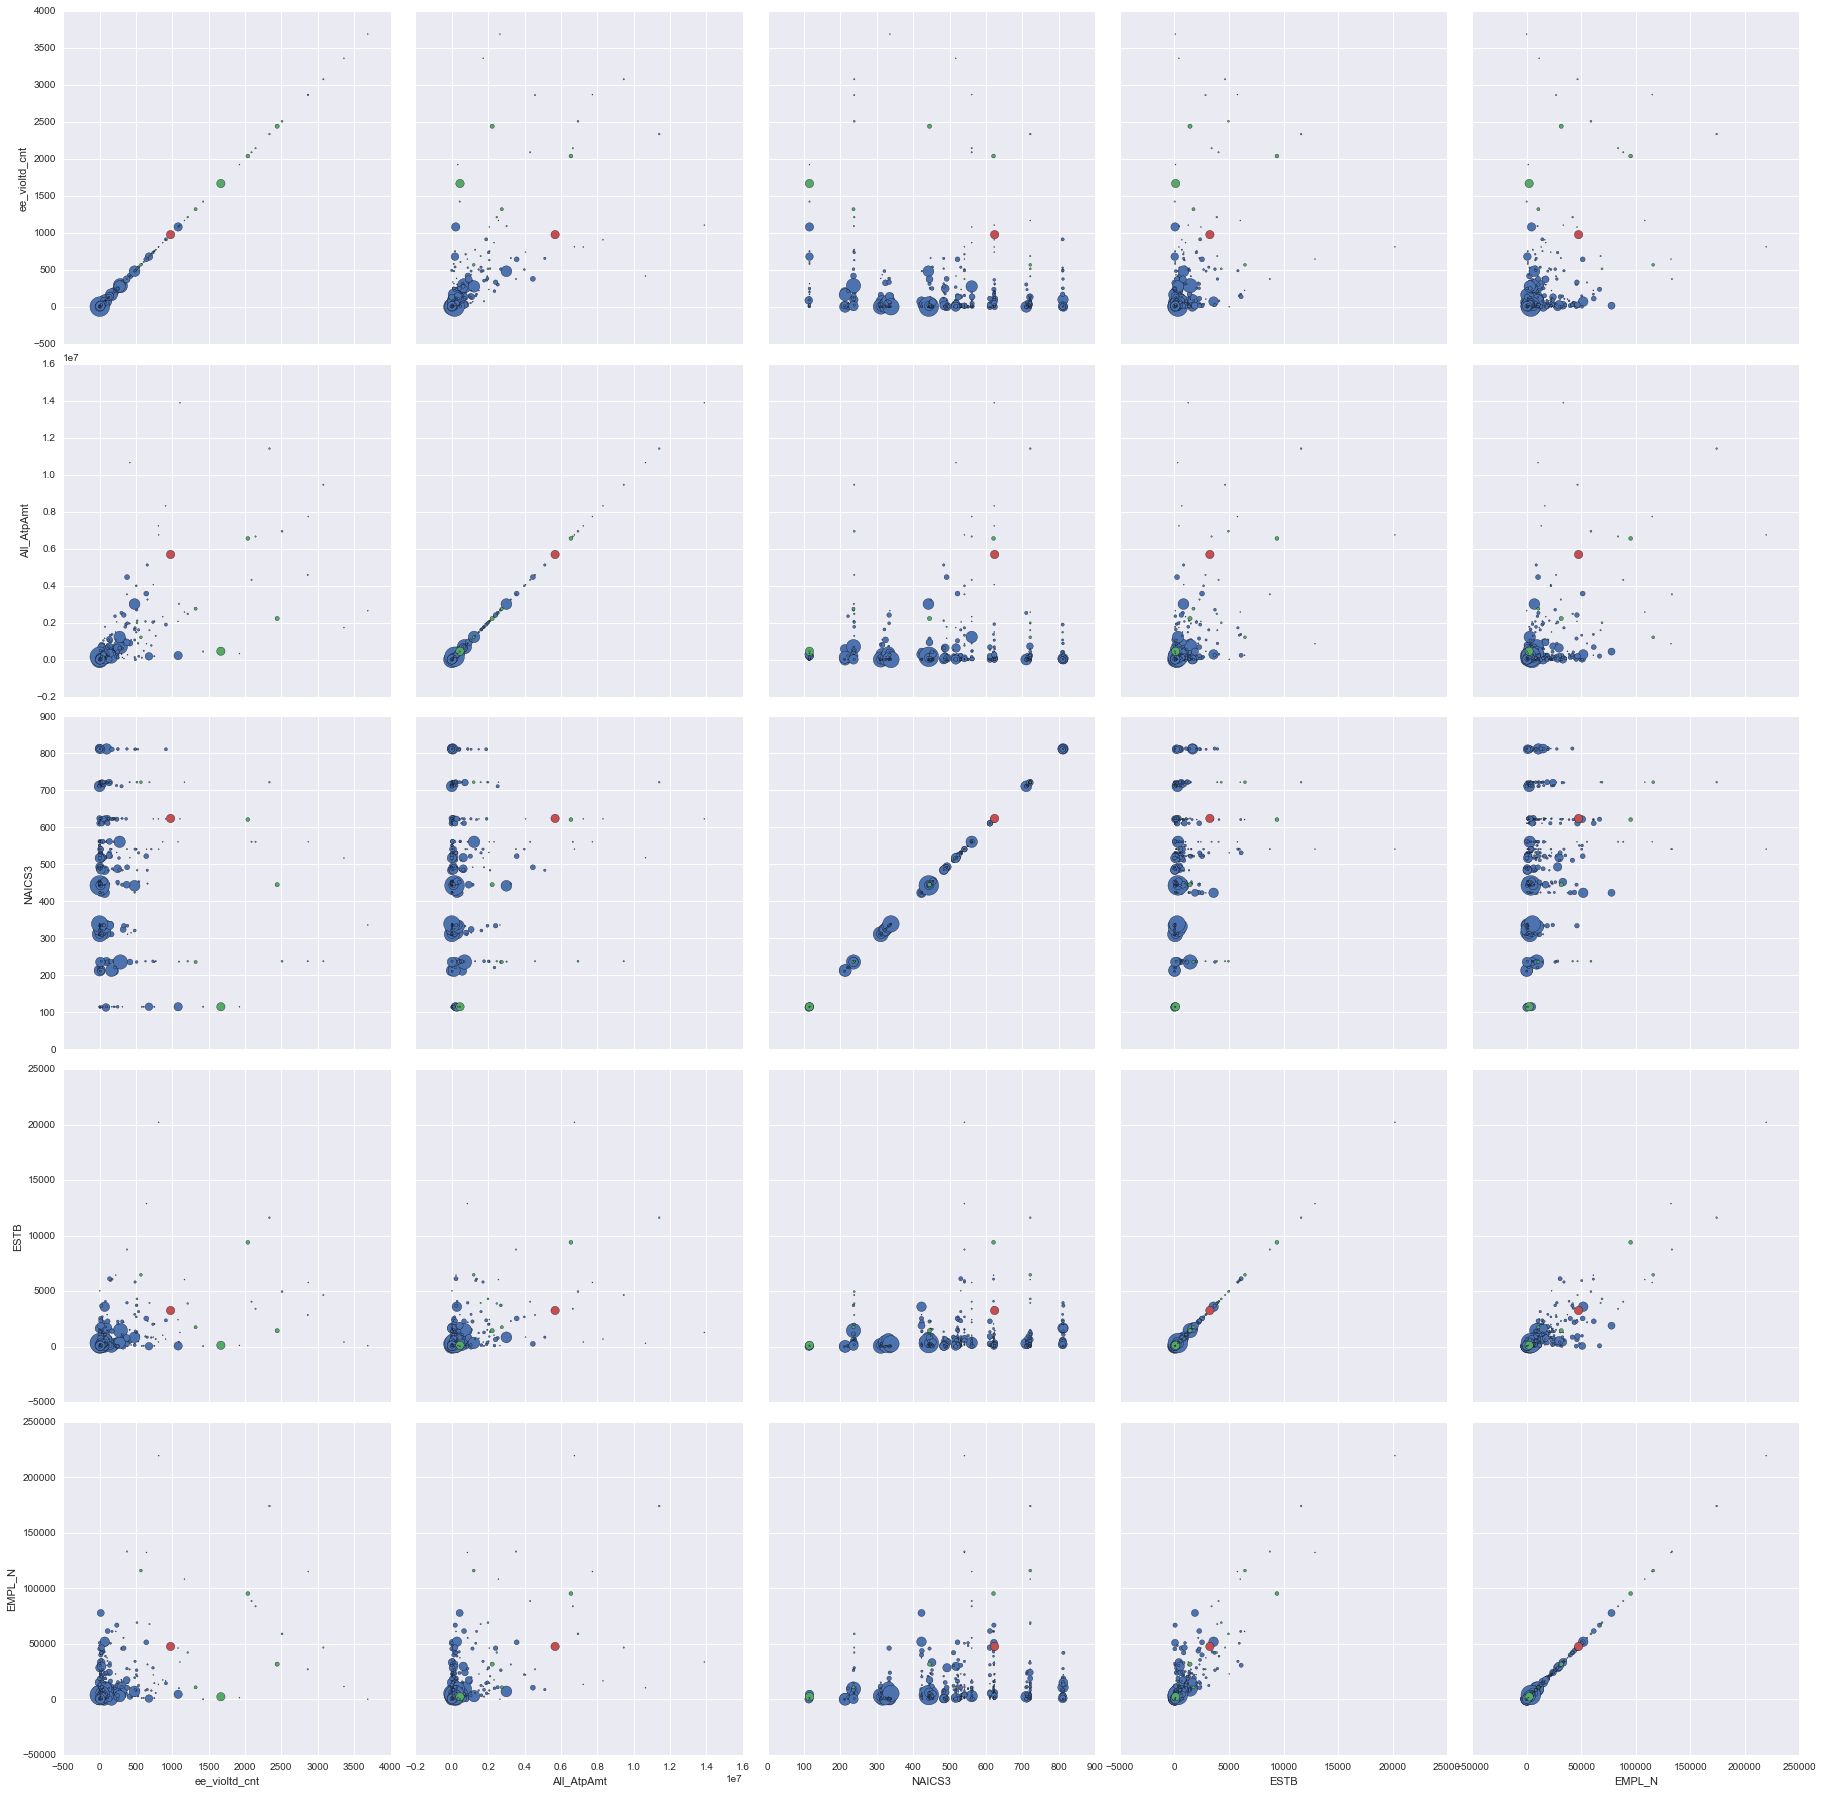

In [155]:
g = sbrn.PairGrid(dat, vars=['ee_violtd_cnt', 'All_AtpAmt','NAICS3','ESTB','EMPL_N'], 
                  size=5, 
                  hue='km_cluster')
#g = g.map_diag(plt.hist)
g.map(plt.scatter, s=dat.num_investigations, edgecolor='black')